In [1]:
import os
from pyomo.environ import *
import mpisppy.utils.sputils as sputils
from mpisppy.opt.ef import ExtensiveForm
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
sys.path.append('../../../../src')
import pandas
import random
import math
import re
from itertools import product
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set
from energiapy.utils.scale_utils import scale_list, scale_tuple
from energiapy.model.constraints.constraints import make_constraint, Cons
from energiapy.model.formulate import constraint_export
from functools import reduce
import pickle
from pyomo.environ import value as pyoval

[    0.00] Initializing mpi-sppy


In [2]:
# _time_intervals = 7  # Number of time intervals in a planning horizon    (L_chi)
_exec_scenarios = 4  # Number of execution scenarios                     (chi)

M = 1e5  # Big M

In [3]:
def create_list(n_total: int, n: int):
    return [1] * n + [0] * (n_total - n)

In [4]:
def create_event_dict(n_total: int):
    default_list = [1] * n_total

    # If event names are same before '_'; they are considered mutually exclusive
    event_dict = {
        'cap2_1': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_2': {'prob': 0.15, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 2)})},
        'cap2_3': {'prob': 0.2, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 3)})},
        'cap2_nd': {'prob': 0.6, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): default_list})},

        'cap4_1': {'prob': 0.01, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 1)})},
        'cap4_2': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_3': {'prob': 0.06, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 3)})},
        'cap4_nd': {'prob': 0.9, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): default_list})},

        'cap7_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): create_list(n_total, 1)})},
        'cap7_2': {'prob': 0.07, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): create_list(n_total, 2)})},
        'cap7_3': {'prob': 0.1, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): create_list(n_total, 3)})},
        'cap7_nd': {'prob': 0.80, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): default_list})},

        'res1_1': {'prob': 0.02, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): create_list(n_total, 1)})},
        'res1_2': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): create_list(n_total, 2)})},
        'res1_3': {'prob': 0.1, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): create_list(n_total, 3)})},
        'res1_nd': {'prob': 0.85, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): default_list})},

        'res6_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 1)})},
        'res6_2': {'prob': 0.06, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 2)})},
        'res6_3': {'prob': 0.11, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        'res6_nd': {'prob': 0.8, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): default_list})},

        'trans12_2': {'prob': 0.2, 'factor': pandas.DataFrame(data={('trans12', 'com1_loc1_out'): create_list(n_total, 2)})},
        'trans12_nd': {'prob': 0.8, 'factor': pandas.DataFrame(data={('trans12', 'com1_loc1_out'): default_list})},

        'trans25_2': {'prob': 0.3, 'factor': pandas.DataFrame(data={('trans25', 'com1_loc2_out'): create_list(n_total, 2)})},
        'trans25_nd': {'prob': 0.7, 'factor': pandas.DataFrame(data={('trans25', 'com1_loc2_out'): default_list})},
    }

    return event_dict

In [5]:
# def remove_scenarios(input_tuples, tuples_to_check):
#     filtered_tuples = []
# 
#     for s_tuple in input_tuples:
#         should_remove = False
# 
#         # Join the tuple elements into a single string for easier processing
#         s = ' '.join(s_tuple)
# 
#         # Loop through each tuple in the list of tuples to check
#         for tuple_group in tuples_to_check:
#             all_have_suffix_1 = True  # Assume all have '_1'
# 
#             # Loop through each element in the tuple
#             for res in tuple_group:
#                 # Build regex pattern to match occurrences like 'res1_1' exactly
#                 res_pattern = fr'{res}_1'
# 
#                 # Check if the pattern 'res_x_1' is in the joined string
#                 if not re.search(res_pattern, s):
#                     all_have_suffix_1 = False
#                     break
# 
#             # If all elements in the tuple have '_1', mark for removal
#             if all_have_suffix_1:
#                 should_remove = True
#                 break
# 
#         # If the tuple doesn't meet removal criteria, add it to the filtered list
#         if not should_remove:
#             filtered_tuples.append(s_tuple)
# 
#     return filtered_tuples

In [6]:
def remove_scenarios(input_tuples, tuples_to_check):
    filtered_tuples = []

    for s_tuple in input_tuples:
        should_remove = False

        # Join the tuple elements into a single string for easier processing
        s = ' '.join(s_tuple)

        # Loop through each tuple in the list of tuples to check
        for tuple_group in tuples_to_check:
            all_present = True
            any_nom = False

            # Loop through each element in the tuple
            for res in tuple_group:
                # Build regex pattern to match occurrences like 'res1_x' where x can be any number
                res_pattern = fr'{res}(_\d+)?'

                # Check if the pattern is in the joined string
                if not re.search(res_pattern, s):
                    all_present = False
                    break

                # Check if '_nom' is in the string
                if f'{res}_nd' in s:
                    any_nom = True

            # If all elements are present and none of them have '_nom', mark for removal
            if all_present and not any_nom:
                should_remove = True
                break

        # If the tuple doesn't meet removal criteria, add it to the filtered list
        if not should_remove:
            filtered_tuples.append(s_tuple)

    return filtered_tuples

In [7]:
# Function to generate the scenario dictionary for n sets of events
def create_scenario_dict(event_dict, remove=None):
    # Extract unique event prefixes (e.g., 'cap2', 'cap4', ...)
    event_prefixes = set(key.split('_')[0] for key in event_dict)

    # Group events by their prefixes
    grouped_events = {prefix: [key for key in event_dict if key.startswith(prefix)] for prefix in event_prefixes}

    # Create all possible combinations of events across the different groups
    filtered_event_combinations = list(product(*grouped_events.values()))
    # print(filtered_event_combinations)

    if remove is not None:
        filtered_event_combinations = remove_scenarios(filtered_event_combinations, remove)
    # print(filtered_event_combinations)

    scenario_dict = {}

    # Iterate over all event combinations
    for combination in filtered_event_combinations:
        # Construct the scenario key
        scenario_key = ' '.join(combination)

        # Calculate the probability of this scenario
        prob = 1
        combined_factor = None

        for event_key in combination:
            # Multiply probabilities
            prob *= event_dict[event_key]['prob']

            # Combine factors (assumes they are pandas DataFrames)
            if combined_factor is None:
                combined_factor = event_dict[event_key]['factor'].copy()
            else:
                combined_factor = combined_factor.add(event_dict[event_key]['factor'], fill_value=0)

        # Add to the scenario dictionary
        scenario_dict[scenario_key] = {'prob': prob, 'factor': combined_factor}
        norm_factor = sum(data['prob'] for key, data in scenario_dict.items())

        for key in scenario_dict:
            scenario_dict[key]['prob'] = scenario_dict[key]['prob']/norm_factor

    return scenario_dict

In [8]:
def build_model(scen_df=pandas.DataFrame()):
    default_df = pandas.DataFrame(data=[1] * _exec_scenarios)
    scale_factor = 90

    # Define temporal scales
    scales = TemporalScale(discretization_list=[1, _exec_scenarios])

    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=225*scale_factor, block={'imp': 1, 'urg': 1}, price=0.00,
                        label='Commodity 1 consumed from outside the system',
                        varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True,
                         label='Commodity 1 sold to outside the system')

    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 500*scale_factor

    # prod_max = {0: 0.25*com1_process_capacity, 1: 0.5*com1_process_capacity, 2: 0.75*com1_process_capacity, 3: 0.95*com1_process_capacity, 4: com1_process_capacity}
    # prod_min = {0: 0, 1: 0.25*com1_process_capacity, 2: 0.5*com1_process_capacity, 3: 0.75*com1_process_capacity, 4: 0.95*com1_process_capacity}
    # rate_max = {0:1.25/2, 1: 1/2, 2: 0.75/2, 3: 0.5/2, 4: 0.25/2}
    # mode_ramp = {(0,1): 5, (1,2): 5}

    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1},
                           capex=25/scale_factor, vopex=0.01, prod_min=0.01, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1},
                        capex=0.1/scale_factor, vopex=0.01, prod_min=0.01, label='Sell com1')
    # com1_opt_procure = Process(name='procure optional com1', prod_max=75, conversion={com1_pur: -1, com1_in:1}, capex=10, vopex=0.1, prod_min=0.01, label='Procure optional com1')

    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity,
                                conversion={com1_loc1_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity,
                                conversion={com1_loc2_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity,
                                conversion={com1_loc3_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity,
                                conversion={com1_loc4_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity,
                                conversion={com1_loc5_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity,
                                conversion={com1_loc6_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity,
                                conversion={com1_loc7_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 7')

    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},
                           capex=5/scale_factor, vopex=0.01, prod_min=0.01, label='Process the commodity through the location',
                           varying=[VaryingProcess.DETERMINISTIC_CAPACITY])

    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.5/scale_factor, vopex=0.01, storage_capex=30/scale_factor, store_min=0.01,
                         store_max=200*scale_factor, prod_min=0.01, label="Storage process", storage=com1_in, storage_cost=0.02)

    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc1_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc2_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc3_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc4_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc5_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc6_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc7_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 7')

    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1',
                    processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store,
                               com1_loc1_send}, label="Location 1",
                    scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1,
                    availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})

    loc2 = Location(name='loc2',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store,
                               com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
                    capacity_scale_level=1, availability_scale_level=1,
                    capacity_factor={com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2',
                                                                                           'com1_process') in scen_df else default_df})

    loc3 = Location(name='loc3',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send},
                    label="Location 3", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1)

    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5,
                                            com1_receive_loc7, com1_process, com1_store, com1_loc4_send},
                    label="Location 4", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1,
                    capacity_factor={com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4',
                                                                                           'com1_process') in scen_df else default_df})

    loc5 = Location(name='loc5',
                    processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store,
                               com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
                    capacity_scale_level=1, availability_scale_level=1)

    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send},
                    label="Location 6", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1,
                    availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})

    loc7 = Location(name='loc7',
                    processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send},
                    label="Location 7", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1,
                    capacity_factor={com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7',
                                                                                           'com1_process') in scen_df else default_df})

    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================

    truck_cap12 = 280*scale_factor
    truck_cap13 = 270*scale_factor
    truck_cap24 = 450*scale_factor
    truck_cap25 = 270*scale_factor
    truck_cap34 = 270*scale_factor
    truck_cap45 = 500*scale_factor
    truck_cap47 = 360*scale_factor
    truck_cap64 = 450*scale_factor
    truck_cap75 = 360*scale_factor

    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12,
                        label='Truck from location 1 to 2', capex=0.5/scale_factor, vopex=0.05, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12,
    #                     label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=0.01)

    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13,
                        label='Truck from location 1 to 3', capex=0.3/scale_factor, vopex=0.03, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13,
    #                     label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=0.01)

    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24,
                        label='Truck from location 2 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24,
    #                     label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=0.01)

    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25,
                        label='Truck from location 2 to 5', capex=0.3/scale_factor, vopex=0.03, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25,
    #                     label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=0.01)

    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34,
                        label='Truck from location 3 to 4', capex=0.2/scale_factor, vopex=0.02, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34,
    #                     label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=0.01)

    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45,
                        label='Truck from location 4 to 5', capex=1/scale_factor, vopex=0.1, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45,
    #                     label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=0.01)

    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47,
                        label='Truck from location 4 to 7', capex=0.4/scale_factor, vopex=0.04, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47,
    #                     label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=0.01)

    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64,
                        label='Truck from location 6 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64,
    #                     label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=0.01)

    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75,
                        label='Truck from location 7 to 5', capex=0.4/scale_factor, vopex=0.04, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75,
    #                     label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=0.01)

    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, M, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [M, 112, M, 95, 0, M, 134],
        [M, M, M, 117, M, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('trans12', 'com1_loc1_out')]] if ('trans12', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc3): {truck13: scen_df[[('trans13', 'com1_loc1_out')]] if ('trans13', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc2, loc4): {truck24: scen_df[[('trans24', 'com1_loc2_out')]] if ('trans24', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc2, loc5): {truck25: scen_df[[('trans25', 'com1_loc2_out')]] if ('trans25', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc3, loc4): {truck34: scen_df[[('trans34', 'com1_loc3_out')]] if ('trans34', 'com1_loc3_out') in scen_df else default_df},
                                                 (loc4, loc5): {truck45: scen_df[[('trans45', 'com1_loc4_out')]] if ('trans45', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc4, loc7): {truck47: scen_df[[('trans47', 'com1_loc4_out')]] if ('trans47', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc6, loc4): {truck64: scen_df[[('trans64', 'com1_loc6_out')]] if ('trans64', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc7, loc5): {truck75: scen_df[[('trans75', 'com1_loc7_out')]] if ('trans75', 'com1_loc7_out') in scen_df else default_df},
                                                 })

    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================

    daily_demand = 400*scale_factor
    demand_penalty = 20

    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

    scenario = Scenario(name='scenario', scales=scales, scheduling_scale_level=1, network_scale_level=0,
                        purchase_scale_level=1, availability_scale_level=1, demand_scale_level=1,
                        capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                        label='Stochastic scenario with Multiple Locations')

    if scen_df.empty:
        # ======================================================================================================================
        # Declare problem
        # ======================================================================================================================

        problem_mincost = formulate(scenario=scenario,
                                    constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                                 Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                                 Constraints.NETWORK},
                                    demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

        scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
        # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
        # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
        
        problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
        
        def first_stage_cost_rule(instance):
            return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) + 
                                                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
        
        problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)

        return scenario, problem_mincost

    else:
        return scenario

In [9]:
def build_smodel(scen_df=pandas.DataFrame()):

    scenario = build_model(scen_df)
    # ======================================================================================================================
    # Declare problem
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                             Constraints.NETWORK},
                                demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

    scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
    
    problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
    
    def first_stage_cost_rule(instance):
        return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) + 
                                            sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
    
    problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)

    return scenario, problem_mincost

In [10]:
def scenario_creator(scen_name, **kwargs):
    scen_dict = kwargs.get('scenario_dict')
    scen, model = build_smodel(scen_df=scen_dict[scen_name]['factor'])
    sputils.attach_root_node(model, model.first_stage_cost,
                             [model.X_P, model.Cap_P, model.X_S, model.Cap_S, model.X_F, model.Cap_F])
    model._mpisppy_probability = scen_dict[scen_name]['prob']
    return model

In [11]:
PI_pickle_dump_folder = r'C:\Users\shivam.vedant\PycharmProjects\energiapy\docs\notebooks\supply chain\AIChE 2024\Pickle Dump'
FD_pickle_dump_folder = r'C:\Users\shivam.vedant\PycharmProjects\energiapy\docs\notebooks\supply chain\AIChE 2024\FD Pickle Dump'

In [12]:
solver_options = {
    'MIPGap': 0.005,
    # 'TimeLimit': 60 * 15,
    'Heuristics': 0.20
}

# event_dict = create_event_dict(n_total=_exec_scenarios)
# scenarios_to_remove = [('res1', 'res6'), ('res1', 'cap4'), ('cap2', 'cap4'), ('trans12', 'cap4'), ('trans25', 'cap4')]
# scenario_dict = create_scenario_dict(event_dict=event_dict, remove=scenarios_to_remove)
# scenario_names = list(scenario_dict.keys())
# 
# with open('scenario_dict.pkl', 'wb') as file:
#     pickle.dump(scenario_dict, file)
# 
# print(f"Sum of probabilities of all scenarios: {sum(scenario_dict[scen]['prob'] for scen in scenario_dict):.6f}")
# print(f'Number of considered scenarios: {len(scenario_names)}')

In [13]:
with open('scenario_dict.pkl', 'rb') as file:
    load_scenario_dict = pickle.load(file)

load_scenario_names = list(load_scenario_dict.keys())

print(f"Sum of probabilities of all scenarios: {sum(load_scenario_dict[scen]['prob'] for scen in load_scenario_dict):.6f}")
print(f'Number of considered scenarios: {len(load_scenario_names)}')

Sum of probabilities of all scenarios: 1.000000
Number of considered scenarios: 496


In [14]:
exCost_PI = 0
results_PI = dict()
scen_PI, model_PI = build_model()

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand penalty location
constraint deman

In [15]:
# # Deterministic Scenarios for Perfect Information
# counter = 0
# PI_output_dict=dict()
# 
# for scen_name in load_scenario_names:
#     scen_PI = build_model(scen_df=load_scenario_dict[scen_name]['factor'])
#     counter+=1
#     # Delete process capacity factors, resource availability factors, transport capacity factors
#     model_PI.del_component('constraint_nameplate_production_varying_capacity')
#     model_PI.del_component('constraint_resource_consumption_varying')
#     model_PI.del_component('constraint_export')
# 
#     # Add the constraints back for this particular scenario
#     model_PI.constraint_nameplate_production_varying_capacity = make_constraint(instance=model_PI,
#         type_cons=Cons.X_LEQ_BY, variable_x='P', location_set=model_PI.locations, component_set=model_PI.processes_varying_capacity,
#         loc_comp_dict=scen_PI.location_process_dict, b_factor=scen_PI.capacity_factor,
#                                                                                 x_scale_level=scen_PI.scheduling_scale_level,
#                                                                                 b_scale_level=scen_PI.capacity_scale_level,
#                                                                                 y_scale_level=scen_PI.network_scale_level,
#                                                                                 variable_y='Cap_P',
#                                                                                 label='restricts production to varying nameplate capacity')
# 
#     model_PI.constraint_resource_consumption_varying = make_constraint(
#         instance=model_PI, type_cons=Cons.X_LEQ_B, variable_x='C', location_set=model_PI.locations,
#         component_set=model_PI.resources_varying_availability, b_max=scen_PI.cons_max,
#         loc_comp_dict=scen_PI.location_resource_dict, b_factor=scen_PI.availability_factor,
#         x_scale_level=scen_PI.scheduling_scale_level, b_scale_level=scen_PI.availability_scale_level,
#         label='restricts resource consumption to varying availablity')
# 
#     constraint_export(instance=model_PI, scheduling_scale_level=scen_PI.scheduling_scale_level,
#                       network_scale_level=scen_PI.network_scale_level,
#                       location_transport_resource_dict=scen_PI.location_transport_resource_dict,
#                       transport_capacity_factor=scen_PI.transport_capacity_factor,
#                       transport_capacity_scale_level=scen_PI.transport_capacity_scale_level)
# 
#     results_PI = solve(scenario=scen_PI, instance=model_PI, solver='gurobi', name=scen_name,
#                        solver_options=solver_options)
# 
#     print(f'######################## Finished solving {scen_name} ({counter} of {len(load_scenario_dict)}) ########################')
# 
#     model_vars = model_PI.component_map(ctype=Var)
#     vars_dict = {i: model_vars[i].extract_values() for i in model_vars.keys()}
#     obj_dict = {'objective': pyoval(model_PI.objective_cost_w_demand_penalty)}
# 
#     PI_output_dict[scen_name] = {**vars_dict, **obj_dict}
# 
#     with open(os.path.join(PI_pickle_dump_folder, scen_name+'.pkl'), 'wb') as file:
#         pickle.dump(PI_output_dict[scen_name], file)
# 
#     exCost_PI += pyoval(model_PI.objective_cost_w_demand_penalty) * load_scenario_dict[scen_name]['prob']

In [16]:
PI_load_dict = dict()
for file in os.listdir(PI_pickle_dump_folder):
    if file.endswith('.pkl'):
        full_file_path = os.path.join(PI_pickle_dump_folder, file)
        
        with open(full_file_path, 'rb') as f:
            PI_load_dict[file.removesuffix('.pkl')] = pickle.load(f)

In [17]:
# print(f"Total Expected Cost considering perfect information: {exCost_PI:.4f}")
# 
# with open('exCost_PI.pkl', 'wb') as file:
#     pickle.dump(exCost_PI, file)
    
with open('exCost_PI.pkl','rb') as file:
    load_exCost_PI = pickle.load(file)

In [18]:
def find_common_substring(lst):
    
    # Split each string into substrings and create sets
    substring_sets = [set(item.split()) for item in lst]
    
    # Find the intersection of all sets to get common substrings
    common_substrings = reduce(lambda a, b: a & b, substring_sets)
    
    return common_substrings

In [19]:
def explore_dict(d, level=0):
    indent = "    " * level  # Indentation for better readability
    for key, value in d.items():
        print(f"{indent}Key: {key}, Type of value: {type(value)}")
        if isinstance(value, dict):  # Recursively explore dictionaries
            explore_dict(value, level + 1)

In [20]:
def filter_scenarios():
    # Initialize the result dictionary
    result = {}
    
    # Step 1: Iterate over the original data
    for scenario, data in PI_load_dict.items():
        x_val = data['Demand_penalty_network'][('com1_sold',0)]
        obj_val = data['objective'] - data['Demand_penalty_network'][('com1_sold',0)]
        
        # Step 2: Check if x_val is already a key in the result
        if x_val not in result:
            result[x_val] = {'count': 0, 'objectives': {}}
        
        # Increment the count for the x value
        result[x_val]['count'] += 1
        
        # Step 3: Check if obj_val is already a key under the 'objectives' for this x
        if obj_val not in result[x_val]['objectives']:
            result[x_val]['objectives'][obj_val] = {'scenarios': [], 'count': 0}
        
        # Add the scenario to the list and increment the count for the objective
        result[x_val]['objectives'][obj_val]['scenarios'].append(scenario)
        result[x_val]['objectives'][obj_val]['count'] += 1
    
    # Step 4: Sort the result by x values (in decreasing order) and objectives (in decreasing order)
    sorted_result = {
        x_val: {
            'count': result[x_val]['count'],
            'count_obj': len(result[x_val]['objectives']),
            'objectives': {
                obj_val: result[x_val]['objectives'][obj_val]
                for obj_val in sorted(result[x_val]['objectives'].keys(), reverse=True)
            }
        }
        for x_val in sorted(result.keys(), reverse=True)
    }
    
    return sorted_result

In [21]:
def pick_scenarios(sorted_dict, n):
    selected_scenarios = {}
    total_selected = 0

    # Iterate over sorted x values
    for x_val, x_data in sorted_dict.items():
        if total_selected >= n:
            break  # Stop if we have selected enough scenarios

        # Iterate over sorted objective values within each x
        for obj_val, obj_data in x_data['objectives'].items():
            if total_selected >= n:
                break  # Stop if we have selected enough scenarios

            # Randomly select from the list of scenarios if there are multiple
            scenarios_to_choose = obj_data['scenarios']
            num_to_pick = min(len(scenarios_to_choose), 1)
            chosen_scenarios = random.sample(scenarios_to_choose, num_to_pick)

            # Add the selected scenarios to the result
            if x_val not in selected_scenarios:
                selected_scenarios[x_val] = {}
            
            if obj_val not in selected_scenarios[x_val]:
                selected_scenarios[x_val][obj_val] = {}

            for scenario in chosen_scenarios:
                selected_scenarios[x_val][obj_val][scenario] = {
                    'prob': load_scenario_dict[scenario]['prob'],
                    'factor': load_scenario_dict[scenario]['factor'].copy()
                }
                total_selected += 1

                if total_selected >= n:
                    break  # Stop if we have selected enough scenarios

    return selected_scenarios

In [22]:
def sum_probabilities(d):
    total_prob = 0
    
    def recursive_sum(current_dict):
        nonlocal total_prob
        for key, value in current_dict.items():
            if isinstance(value, dict):
                # Recursively traverse if it's still a dictionary
                recursive_sum(value)
            elif key == 'prob':
                # Add the probability value
                total_prob += value

    recursive_sum(d)
    return total_prob

In [23]:
sorted_result = filter_scenarios()

In [24]:
sum(data['count_obj'] for key, data in sorted_result.items())

159

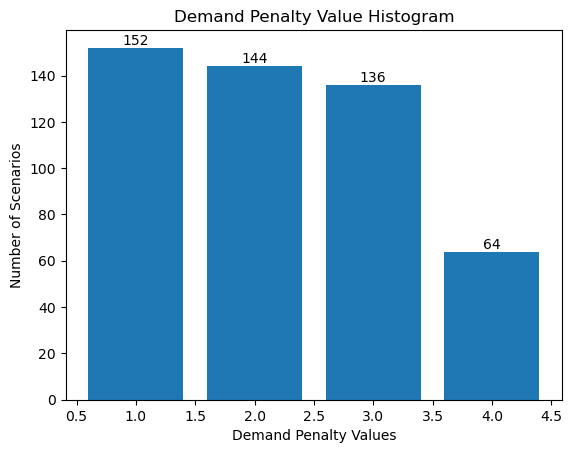

In [25]:
# Example data
n = len(list(sorted_result.keys()))
list1 = [i for i in range(1,n+1)]  # X-axis labels
list2 = [sorted_result[key]['count'] for key, data in sorted_result.items()]

# Create a bar chart
plt.bar(list1, list2)

# Add labels and title
plt.xlabel('Demand Penalty Values')
plt.ylabel('Number of Scenarios')
plt.title('Demand Penalty Value Histogram')

for i, value in enumerate(list2):
    plt.text(i+1, value, str(value), ha='center', va='bottom')

# Rotate the x-axis labels if they are too long or overlapping
plt.xticks()

# Show the plot
plt.show()

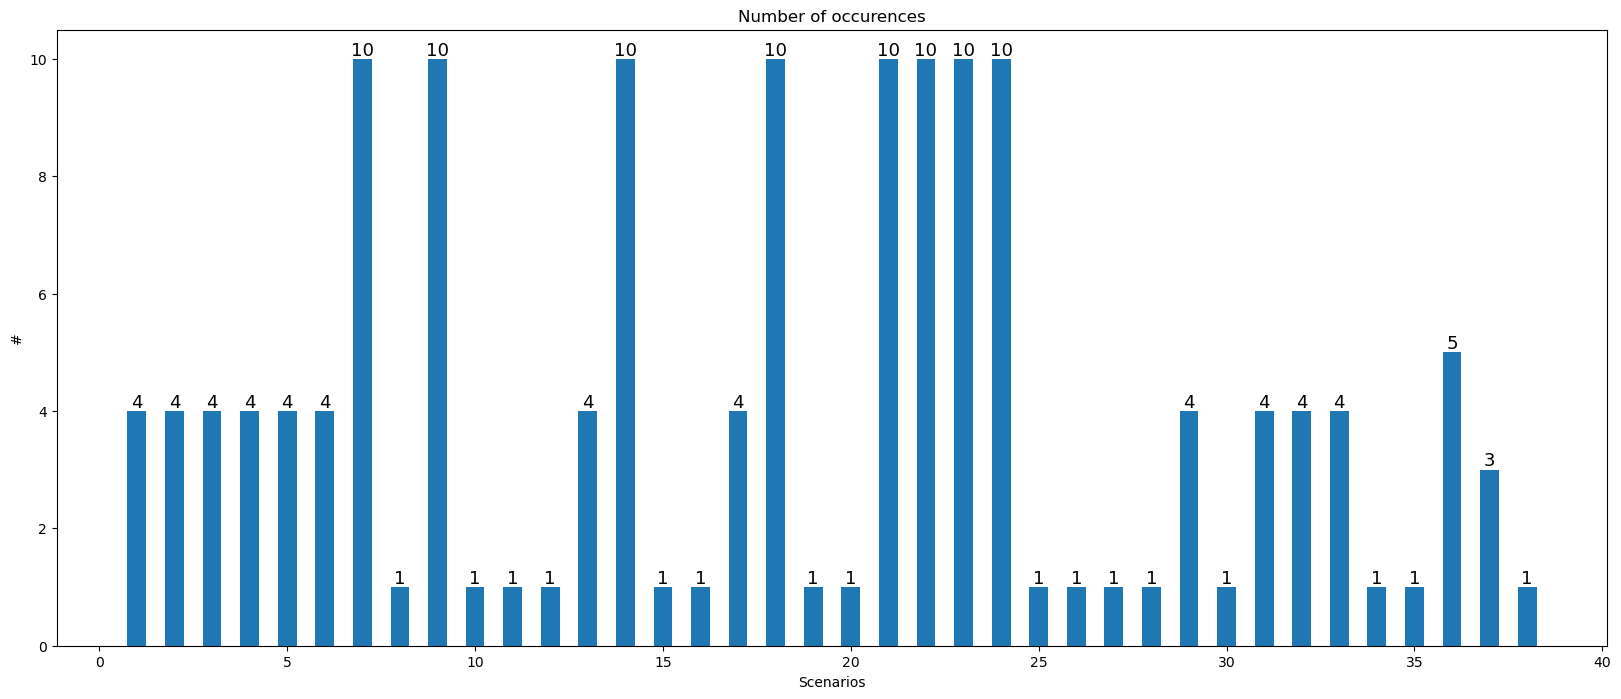

In [26]:
# Example data

penalty_key = list(sorted_result.keys())[0]
n = len(list(sorted_result[penalty_key]['objectives'].keys()))
obj_keys = [list(sorted_result[penalty_key]['objectives'].keys())[i] for i in range(n)]
list1 = [i for i in range(1,n+1)]  # X-axis labels
list2 = [sorted_result[penalty_key]['objectives'][obj_keys[i]]['count'] for i in range(n)]

plt.figure(figsize=(20,8))

# Create a bar chart
plt.bar(list1, list2, width = 0.5)

# Add labels and title
plt.xlabel('Scenarios')
plt.ylabel('#')
plt.title('Number of occurences')

for i, value in enumerate(list2):
    plt.text(i+1, value, str(value), ha='center', va='bottom', fontsize=13)

# Rotate the x-axis labels if they are too long or overlapping
# plt.xticks(rotation=45)

# Show the plot
plt.show()

In [123]:
k1 = list(sorted_result.keys())[0]
k2 = list(sorted_result[k1]['objectives'].keys())[6]

sorted_result[k1]['objectives'][k2]['scenarios']

['trans25_2 res6_nd cap4_nd cap7_1 trans12_2 cap2_2 res1_1',
 'trans25_2 res6_nd cap4_nd cap7_1 trans12_2 cap2_3 res1_1',
 'trans25_2 res6_nd cap4_nd cap7_1 trans12_2 cap2_nd res1_1',
 'trans25_2 res6_nd cap4_nd cap7_1 trans12_nd cap2_2 res1_1',
 'trans25_2 res6_nd cap4_nd cap7_1 trans12_nd cap2_3 res1_1',
 'trans25_2 res6_nd cap4_nd cap7_1 trans12_nd cap2_nd res1_1',
 'trans25_nd res6_nd cap4_nd cap7_1 trans12_2 cap2_2 res1_1',
 'trans25_nd res6_nd cap4_nd cap7_1 trans12_2 cap2_3 res1_1',
 'trans25_nd res6_nd cap4_nd cap7_1 trans12_2 cap2_nd res1_1',
 'trans25_nd res6_nd cap4_nd cap7_1 trans12_nd cap2_2 res1_1']

In [124]:
find_common_substring(sorted_result[k1]['objectives'][k2]['scenarios'])

{'cap4_nd', 'cap7_1', 'res1_1', 'res6_nd'}

In [107]:
scenarios_to_select = 150
random.seed(2)
selected_scenarios = pick_scenarios(sorted_result, scenarios_to_select)

In [108]:
norm_factor = sum_probabilities(selected_scenarios)
selected_scenario_dict = {
    k: {
        'prob': scenario_data['prob'] / norm_factor,
        'factor': scenario_data['factor'].copy()
    }
    for i, inner_dict in selected_scenarios.items()
    for j, sub_dict in inner_dict.items()
    for k, scenario_data in sub_dict.items()
}
            
selected_scenario_names = list(selected_scenario_dict.keys())
print(f'Number of scenarios considered: {len(selected_scenario_names)}')
prob_select = sum_probabilities(selected_scenario_dict)
print(f'Sum of probabilities for selected scenarios: {prob_select}')

Number of scenarios considered: 150
Sum of probabilities for selected scenarios: 1.0


In [109]:
options = {"solver": "gurobi"}
scenario_creator_kwargs = {'scenario_dict': load_scenario_dict}
ef_UI = ExtensiveForm(options, selected_scenario_names, scenario_creator, scenario_creator_kwargs=scenario_creator_kwargs)
results = ef_UI.solve_extensive_form(solver_options=solver_options)

[ 3858.44] Initializing SPBase
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand pe

In [111]:
exCost_UI = ef_UI.get_objective_value()
# exCost_UI

with open(fr'{FD_pickle_dump_folder}\{scenarios_to_select}\exCost_{scenarios_to_select}_UI.pkl', 'wb') as file:
    pickle.dump(exCost_UI, file)
    
with open(fr'{FD_pickle_dump_folder}\{scenarios_to_select}\exCost_{scenarios_to_select}_UI.pkl', 'rb') as file:
    load_exCost_UI = pickle.load(file)

In [112]:
# exCost_UI = 2133007.7662
EVPI = load_exCost_UI - load_exCost_PI
p_inc = EVPI * 100 / load_exCost_PI
p_dec = EVPI * 100 / exCost_UI

In [113]:
print(f"Total Expected Cost considering perfect information: {load_exCost_PI:.4f}")
print(f"Total Expected Cost considering disruptions (stochastic solution): {load_exCost_UI:.4f}")
print(f"Expected Value of Perfect Information: {EVPI:.4f}")
print(f"Percentage Increase in Cost: {p_inc:.4f}%%")
print(f"Percentage Decrease in Cost: {p_dec:.4f}%%")

Total Expected Cost considering perfect information: 2026549.7304
Total Expected Cost considering disruptions (stochastic solution): 2287709.2953
Expected Value of Perfect Information: 261159.5649
Percentage Increase in Cost: 12.8869%%
Percentage Decrease in Cost: 11.4158%%


In [114]:
ssoln_dict = ef_UI.get_root_solution()

with open(fr'{FD_pickle_dump_folder}\{scenarios_to_select}\ssoln_{scenarios_to_select}_UI.pkl', 'wb') as file:
    pickle.dump(ssoln_dict, file)
    
with open(fr'{FD_pickle_dump_folder}\{scenarios_to_select}\ssoln_{scenarios_to_select}_UI.pkl', 'rb') as file:
    load_ssoln_dict = pickle.load(file)

# FIXED DESIGN

In [115]:
exCost_FD = 0
exDF_FD = 0
results_FD = dict()
scen_FD, model_FD = build_model()

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand penalty location
constraint deman

In [116]:
def fix_variables(model1: ConcreteModel, model2:ConcreteModel, scen_name:str):
    # vars_to_fix = ['X_P', 'Cap_P', 'X_S', 'Cap_S', 'X_F', 'Cap_F']
    model = getattr(model1, scen_name)
    def fix(var1, var2):
        for i in list(var1.keys()):
            if var1[i].value is None:
                continue
            else:
                var2[i].fixed = True
                var2[i] = var1[i].value
            # var2[i].pprint()
            
    fix(model.X_P, model2.X_P)
    fix(model.Cap_P, model2.Cap_P)
    fix(model.X_S, model2.X_S)
    fix(model.Cap_S, model2.Cap_S)
    fix(model.X_F, model2.X_F)
    fix(model.Cap_F, model2.Cap_F)

In [117]:
# Deterministic Scenarios for Fixed Design
counter = 0
FD_output_dict=dict()
fix_variables(model1=ef_UI.ef, model2=model_FD, scen_name=selected_scenario_names[0])

for scen_name in load_scenario_names:
    scen_FD = build_model(scen_df=load_scenario_dict[scen_name]['factor'])
    counter+=1
    # Delete process capacity factors, resource availability factors, transport capacity factors
    model_FD.del_component('constraint_nameplate_production_varying_capacity')
    model_FD.del_component('constraint_resource_consumption_varying')
    model_FD.del_component('constraint_export')

    # Add the constraints back for this particular scenario
    model_FD.constraint_nameplate_production_varying_capacity = make_constraint(instance=model_FD,
        type_cons=Cons.X_LEQ_BY, variable_x='P', location_set=model_FD.locations, component_set=model_FD.processes_varying_capacity,
        loc_comp_dict=scen_FD.location_process_dict, b_factor=scen_FD.capacity_factor,
                                                                                x_scale_level=scen_FD.scheduling_scale_level,
                                                                                b_scale_level=scen_FD.capacity_scale_level,
                                                                                y_scale_level=scen_FD.network_scale_level,
                                                                                variable_y='Cap_P',
                                                                                label='restricts production to varying nameplate capacity')

    model_FD.constraint_resource_consumption_varying = make_constraint(
        instance=model_FD, type_cons=Cons.X_LEQ_B, variable_x='C', location_set=model_FD.locations,
        component_set=model_FD.resources_varying_availability, b_max=scen_FD.cons_max,
        loc_comp_dict=scen_FD.location_resource_dict, b_factor=scen_FD.availability_factor,
        x_scale_level=scen_FD.scheduling_scale_level, b_scale_level=scen_FD.availability_scale_level,
        label='restricts resource consumption to varying availablity')

    constraint_export(instance=model_FD, scheduling_scale_level=scen_FD.scheduling_scale_level,
                      network_scale_level=scen_FD.network_scale_level,
                      location_transport_resource_dict=scen_FD.location_transport_resource_dict,
                      transport_capacity_factor=scen_FD.transport_capacity_factor,
                      transport_capacity_scale_level=scen_FD.transport_capacity_scale_level)

    results_FD = solve(scenario=scen_FD, instance=model_FD, solver='gurobi', name=scen_name,
                       solver_options=solver_options)

    print(f'######################## Finished solving {scen_name} ({counter} of {len(load_scenario_dict)}) ########################')

    model_vars = model_FD.component_map(ctype=Var)
    vars_dict = {i: model_vars[i].extract_values() for i in model_vars.keys()}
    obj_dict = {'objective': pyoval(model_FD.objective_cost_w_demand_penalty)}

    FD_output_dict[scen_name] = {**vars_dict, **obj_dict}
    
    with open(fr"{FD_pickle_dump_folder}\{len(selected_scenario_names)}\{scen_name}.pkl", 'wb') as file:
        pickle.dump(FD_output_dict[scen_name], file)

    exCost_FD += pyoval(model_FD.objective_cost_w_demand_penalty) * load_scenario_dict[scen_name]['prob']
    exDF_FD += pyoval(model_FD.Demand_penalty_network[('com1_sold',0)]) * load_scenario_dict[scen_name]['prob']

constraint export
Set parameter MIPGap to value 0.005
Set parameter Heuristics to value 0.2
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 9763 rows, 18517 columns and 13154 nonzeros
Model fingerprint: 0xcc6be250
Variable types: 17936 continuous, 581 integer (581 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+01]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 4e+04]
  RHS range        [1e+01, 5e+04]
Presolve removed 9753 rows and 18500 columns
Presolve time: 0.02s
Presolved: 10 rows, 17 columns, 33 nonzeros
Variable types: 17 continuous, 0 integer (0 binary)

Root relaxation: objective 2.406815e+06, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    

In [118]:
final_results_dict = {len(selected_scenario_names): {'Expected Cost UI': load_exCost_UI,
                                            'Expected Cost FD': exCost_FD,
                                            'Expected Resilience': 1- exDF_FD/(20*400*90*4)}}
    
with open(fr"{FD_pickle_dump_folder}\{len(selected_scenario_names)}\FD_{len(selected_scenario_names)}_final_results.pkl", 'wb') as file:
    pickle.dump(final_results_dict, file)

In [119]:
final_results_dict

{150: {'Expected Cost UI': 2287709.295251497,
  'Expected Cost FD': 2061960.940749143,
  'Expected Resilience': 0.9925237006417899}}